In [ ]:
#Загружаем библиотеки
import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
import matplotlib.dates as mdates
from datetime import datetime
import random as random 

from tensorflow.keras import utils #Для to_categorical
import numpy as np #Numpy
import math
import time
from tensorflow.keras.optimizers import Adam, RMSprop #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D #Стандартные слои
from tensorflow.keras.backend import std, mean, abs
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов
from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model


# Рисовать графики сразу же
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Функции и процедуры

In [ ]:
def cleanMinMax(arr, minmax):
  for i in range(0, arr.shape[0]):
    if arr[i,0] > minmax:
      arr[i,0] = minmax
      continue
    if arr[i,0] < -minmax:
      arr[i,0] = -minmax 

def showBarPlot(ds1, ds2, col_n):
  x1 = ds1.index.values 
  x2 = ds2.index.values 
  y1 = np.array(ds1.iloc[:,col_n])
  y1 = np.reshape(y1, (y1.shape[0]))
  y2 = np.array(ds2.iloc[:,col_n])
  y2 = np.reshape(y2, (y2.shape[0]))
  x1 = np.arange(1, y1.shape[0]+1) - 0.1
  x2 =[x1 + 0.1 for x2 in x1]
  fig, ax = plt.subplots(figsize=(20, 10))
  ax.bar(x1, y1, width = 0.2)
  ax.bar(x2, y2, width = 0.2)
  plt.show()      


def showBarPlot4(ds1, ds2, ds3, ds4, col_n, labels):
  barWidth = 0.2
  y1 = np.array(ds1.iloc[:, col_n])
  y1 = np.reshape(y1, (y1.shape[0]))
  y2 = np.array(ds2.iloc[:, col_n])
  y2 = np.reshape(y2, (y2.shape[0]))
  y3 = np.array(ds3.iloc[:, col_n])
  y3 = np.reshape(y3, (y3.shape[0]))
  y4 = np.array(ds4.iloc[:, col_n])
  y4 = np.reshape(y4, (y4.shape[0]))

  x1 = np.arange(1, y1.shape[0] + 1) - 2 * barWidth
  x2 = np.arange(1, y2.shape[0] + 1) - barWidth
  x3 = np.arange(1, y3.shape[0] + 1)
  x4 = np.arange(1, y4.shape[0] + 1) + barWidth

  fig, ax = plt.subplots(figsize=(20, 10))

  ax.bar(x1, y1, width=0.2, label=labels[0])
  ax.bar(x2, y2, width=0.2, label=labels[1])
  ax.bar(x3, y3, width=0.2, label=labels[2])
  ax.bar(x4, y4, width=0.2, label=labels[3])

  dates = []
  for val in ds1.DateTime:
      dates.append(val[-5:])
  plt.xticks([r + barWidth + 0.7 for r in range(len(dates))], np.array(dates))
  plt.legend(loc='upper left')
  plt.show() 

# Функция принимает на вход датасет и возвращает свернутую таблицу по дням 
def convertToDaysTable(ds1, savename=''):
  newDataSet = pd.DataFrame()
  newDataSet['DateTime'] = pd.to_datetime('2020-01-01 00:00:00')
  newDataSet['Diff'] = 0
  newDataSet['Diff'] = newDataSet['Diff'].astype('int32')
  newDataSet['Inc Vol'] = 0
  newDataSet['Inc Vol'] = newDataSet['Inc Vol'].astype('int32')
  dataSet = ds1
  for index in dataSet.index:
      t = datetime.strptime(USA_Data.loc[index, 'DateTime'], '%Y-%m-%d %H:%M:%S').date().strftime('%Y-%m-%d')
      newDataSet = newDataSet.append({'DateTime': pd.to_datetime(t),  # Оставляем только дату, потом сгруппируем
                                      'Diff': dataSet.loc[index, 'Diff'],
                                      'Inc Vol': dataSet.loc[index, 'Inc Vol']}, ignore_index=True)
  newDataSet = newDataSet.groupby('DateTime').sum()
  if savename != '':
      _ = pd.DataFrame.to_csv(newDataSet, savename + '.csv')
  return newDataSet

# Функция возвращает значение первого рабочего часа нужного датасета
def getFirstHourValue(dataSet, findStr):
  val = None
  found = dataSet.loc[dataSet['DateTime'] == findStr]
  if len(found.index) > 0:
      i = found.index[0]
      val = 0
      for el in np.array(dataSet.iloc[i:i + 6, 1:2]):
          val += el[0]
  else:
      print('Not found ' + findStr)
  return val

def showUnscaled(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

def showCompare(dataSet1, dataSet2, index, result):
  if result > 0.99:
      print('Показана прямая зависимость тенденции в течении заданного количества временных единиц')
  elif result < 0.009:
      print('Показана обратная зависимость тенденции в течении заданного количества временных единиц')
  else:
      print('Зависимость не обнаружена')

  time1 = np.array(dataSet1.iloc[indeX1[index]:indeX1[index] + numOfNeuronsY, 0:1], dtype='datetime64')
  data1 = np.array(dataSet1.iloc[indeX1[index]:indeX1[index] + numOfNeuronsY, 1:2])
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
  plt.plot(time1, data1)
  plt.gcf().autofmt_xdate()
  plt.show()

  time1 = np.array(dataSet2.iloc[indeX2[index]:indeX2[index] + numOfNeuronsY, 0:1], dtype='datetime64')
  data1 = np.array(dataSet2.iloc[indeX2[index]:indeX2[index] + numOfNeuronsY, 1:2])
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
  plt.plot(time1, data1)
  plt.gcf().autofmt_xdate()
  plt.show()  

# Загрузка и обработка датасетов

In [ ]:
#Считываем данные с помощью pandas
dtype_dic= { 'Date':'str', 'Time':'str', 'Close':'float64', 'Open':'float64' }
dataSet = pd.read_csv('/content/drive/MyDrive/Тестовые задания/China.csv', dtype=dtype_dic)
dataSet = dataSet.drop(['Volume'], axis =1)  
dataSet = dataSet.drop(['High'], axis =1)  
dataSet = dataSet.drop(['Low'], axis =1)
dataSet.reset_index(inplace=True)                    
dataSet = dataSet.drop('index',axis=1)

In [ ]:
# Создаем новый датасет и уменьшаем данные для анализа в 10 раз
# Будем анализировать данные по тенденции роста/падения Close - Open
newDataSet = pd.DataFrame()
newDataSet['DateTime'] = pd.to_datetime('2020-01-01 00:00:00')
newDataSet['Diff'] = 0
newDataSet['Diff'] = newDataSet['Diff'].astype('int32')
newDataSet['Inc Vol'] = 0
newDataSet['Inc Vol'] = newDataSet['Inc Vol'].astype('int32')

for index in dataSet.index:
  t = datetime.strptime(dataSet.loc[index,'Time'], '%H:%M:%S').time()
  newDataSet = newDataSet.append({'DateTime': pd.to_datetime(dataSet.loc[index,'Date'] + ' ' + t.strftime("%H:%M")[0:4] +"0:00"), #берем часы и по 10 минут только
                                           #+ dataSet.loc[index,'Time'][0:4]+'0:00 '+dataSet.loc[index,'Time'][-2:]), 
                                  'Diff':dataSet.loc[index,'Close'] - dataSet.loc[index,'Open'],
                                  'Inc Vol':dataSet.loc[index,'Inc Vol']}, ignore_index=True)
# Сворачиваем данные с шагом в 10 минут
newDataSet = newDataSet.groupby('DateTime').sum()
# Сохраняем данные на диск
newDataSet = pd.DataFrame.to_csv(newDataSet, 'China_Done.csv')

# Загружаем все датасеты в память

In [ ]:
USA_Data = pd.read_csv('/content/drive/MyDrive/Тестовые задания/USA_Done.csv',)
EURO_Data = pd.read_csv('/content/drive/MyDrive/Тестовые задания/EURO_Done.csv',)
EURO_Data = EURO_Data.drop(['Unnamed: 0'], axis =1) 
China_Data = pd.read_csv('/content/drive/MyDrive/Тестовые задания/China_Done.csv',)
JPN_Data = pd.read_csv('/content/drive/MyDrive/Тестовые задания/JPN_Done.csv',)

USA_byDays = pd.read_csv('/content/drive/MyDrive/Тестовые задания/USA_byDays.csv',)
China_byDays = pd.read_csv('/content/drive/MyDrive/Тестовые задания/China_byDays.csv',)
Japan_byDays = pd.read_csv('/content/drive/MyDrive/Тестовые задания/Japan_byDays.csv',)
Euro_byDays = pd.read_csv('/content/drive/MyDrive/Тестовые задания/Euro_byDays.csv',)

# Поиск тенденций роста/убывания

In [ ]:
def doPredict(dataSetSource, dataSetTarget, minMaxSource=30, minMaxTarget=30, analizTime = 144):
  startPos = 0
  Val1 = []
  Val2 = []
  indeX1 = []
  indeX2 = []
  xVal1 = dataSetSource.iloc[:,1:2]
  xVal2 = dataSetTarget.iloc[:,1:2]
  xVal1 = np.array(xVal1)
  xVal2 = np.array(xVal2)
  cleanMinMax(xVal1, minMaxSource)
  cleanMinMax(xVal2, minMaxTarget)

  for i in range(startPos, len(xVal1)-numOfNeuronsY, numOfNeuronsY):
    tek1 = xVal1[i:i+numOfNeuronsY]

    # Берем дату из первого датасета и ищем ее во втором датасете
    # Нужно найти точку старта во втором датасете
    j = i
    findThisDate = dataSetSource.iloc[i,0:1][0]
    found = dataSetTarget.loc[dataSetTarget['DateTime'] == findThisDate]
    if len(found.index)>0:
      j = found.index[0]
    else:
      #print('Not found '+findThisDate)
      continue # Если не нашли дату то пропускаем  
    rightSide = j + analizTime # Смотрим на analizTime временных единиц вперед
    
    while j+numOfNeuronsY < rightSide and j < len(xVal2)-numOfNeuronsY:
      tek2 = xVal2[j:j+numOfNeuronsY]
      Val1.append(tek1)
      Val2.append(tek2)
      indeX1.append(i)
      indeX2.append(j)
      j += 1

  xVal1 = np.array(Val1)
  xVal2 = np.array(Val2)

  xVal1 = np.reshape(xVal1, (xVal1.shape[0], xVal1.shape[1]))
  xVal2 = np.reshape(xVal2, (xVal2.shape[0], xVal2.shape[1]))

  ScalerX1 = MinMaxScaler(feature_range=(0, 1))
  ScalerX1.fit(xVal1)
  xVal1 = ScalerX1.transform(xVal1)

  ScalerX2 = MinMaxScaler(feature_range=(0, 1))
  ScalerX2.fit(xVal2)
  xVal2 = ScalerX2.transform(xVal2)

  # Обрабатываем результат 
  model = makeModelComparator6()
  model.load_weights('/content/drive/MyDrive/Тестовые задания/model_comparator_6.h5')
  res = model.predict([xVal1, xVal2])

  directRelationships = 0
  antiderectRelationships = 0
  i = 0  
  for val in res:
    if val > 0.99:
      directRelationships +=1
    if val < 0.01:
      antiderectRelationships +=1
    i+=1

  print('Прямых зависимостей: '+str(directRelationships))
  print('Обратных зависимостей: '+str(antiderectRelationships))
  return res, indeX1, indeX2, xVal1, xVal2

def makeInputModel(input_shape = (numOfNeuronsY, 1)):
    inputLayer = Input(input_shape) 
    x = Conv1D(8, 6, activation='relu', padding='same')(inputLayer)      
    x = Dropout(0.2)(x)
    x = Conv1D(8, 6, activation='relu', padding='same')(x) 
    x = Dropout(0.2)(x)
    x = MaxPooling1D(pool_size=2)(x)
    model = Flatten()(x)
    return model, inputLayer # Возвращаем сформированную модель

def makeModelComparator6():
  leftSideModel, inputLayerLeft = makeInputModel(input_shape= (numOfNeuronsY, 1))
  rightSideModel, inputLayerRight = makeInputModel(input_shape= (numOfNeuronsY, 1))

  x = concatenate([leftSideModel, rightSideModel])
  x = Dense(32, activation='relu')(x)
  out = Dense(1, activation='sigmoid')(x)
  model = Model(inputs=[inputLayerLeft, inputLayerRight], outputs=out)
    # Компилируем модель
  model.compile(optimizer=Adam(lr=1e-3),
                loss='mse')
  return model


In [ ]:
# Анализируем паттерны роста/убывания в течении 6 временных единиц (6*10минут)
numOfNeuronsY = 6 
res, indeX1, indeX2, xVal1, xVal2 = doPredict(China_Data, USA_Data, minMaxSource=100, minMaxTarget=100, analizTime=144)

Прямых зависимостей: 836
Обратных зависимостей: 278


In [ ]:
# Выведем список похожих патернов
for i in range(0, res.shape[0]):
  if res[i]>0.999:
    print(i) 

820272
823458


Показана прямая зависимость тенденции в течении заданного количества временных единиц


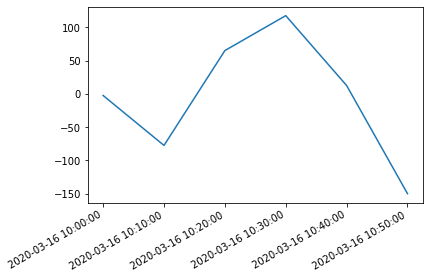

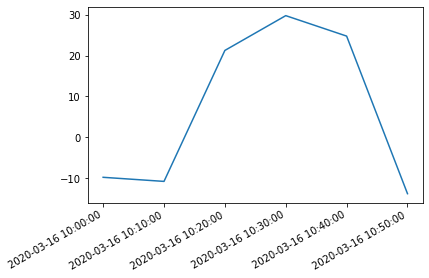

In [ ]:
showCompare(China_Data, USA_Data, 820272, res[820272])

In [ ]:
# Выведем список похожих антипатернов
for i in range(0, res.shape[0]):
  if res[i]<0.001:
    print(i) 

816627
816891


Показана обратная зависимость тенденции в течении заданного количества временных единиц


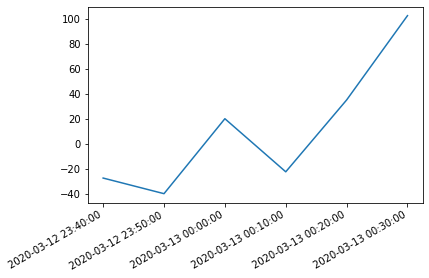

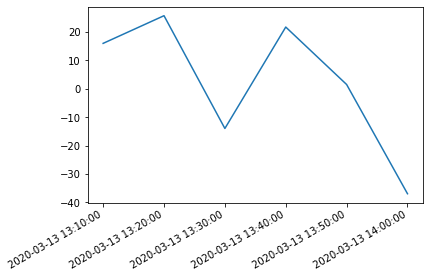

In [ ]:
showCompare(China_Data, USA_Data, 816627, res[816627])

# Азиатский рынок и американский рынок (первый час торгов основной  сессии)

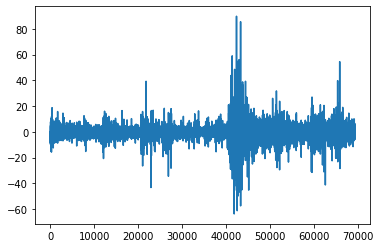

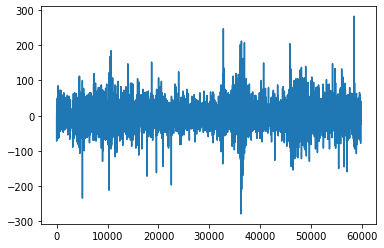

In [ ]:
# Смотрим график USA и China
plt.plot(USA_Data.iloc[:,1:2])
plt.show()
plt.plot(China_Data.iloc[:,1:2])
plt.show()

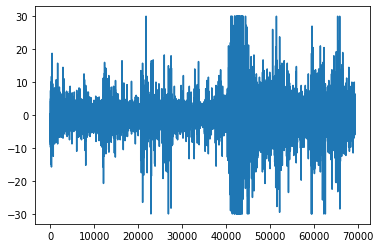

In [ ]:
# Обрежем все значения >30
USA_NP_Data = np.array(USA_Data.iloc[:,1:2])
cleanMinMax(USA_NP_Data, 30)
plt.plot(USA_NP_Data,   label='USA')
plt.show()

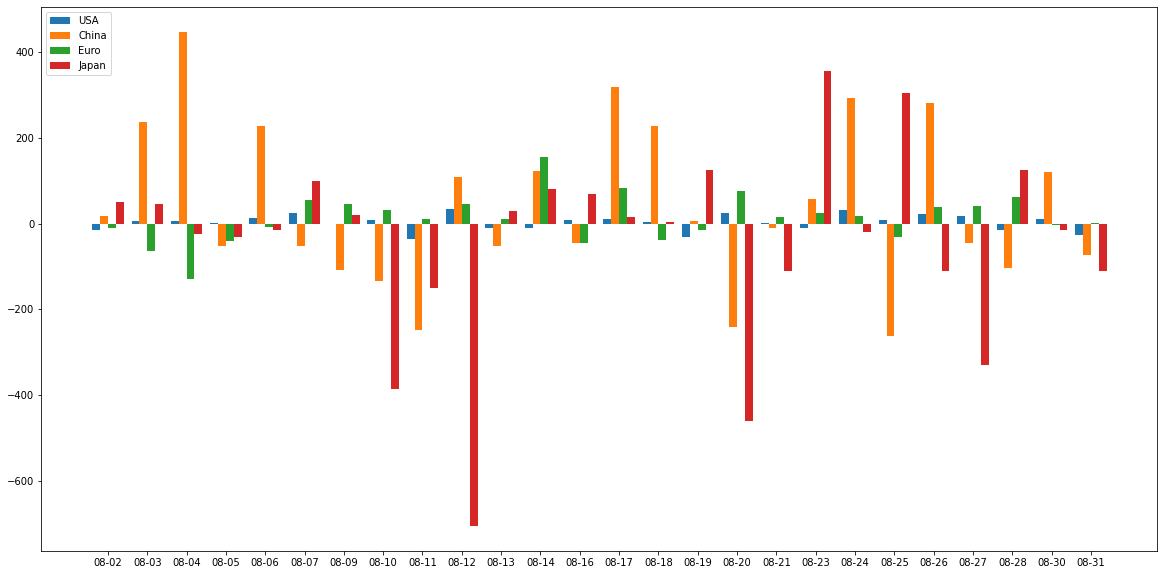

In [ ]:
# Отобразим графики всех бирж за месяц
period = [i for i in range(494,520)]
showBarPlot4(ds1 = USA_byDays.iloc[period,:]
             , ds2 = China_byDays.iloc[period,:]
             , ds3 = Euro_byDays.iloc[period,:]
             , ds4 = Japan_byDays.iloc[period,:]
             , col_n = 1
             , labels = ['USA', 'China', 'Euro', 'Japan'])

In [ ]:
# Китай работает с 20 EST по 02 EST
# США работает с 09 EST по 15 EST
# Евро работает с 02 EST по 10 EST
exchangeSourceTimeStartWork = 20
exchangeTargetTimeStartWork = 9

# Создаем данные для проверки из Китая 
periodOfWork = 6*6 # в датасете строка = 10 минут, соответствено 6 часов работы Китая = 6*6

dataSetSource = China_Data.iloc[:,:]
dataSetTarget = USA_Data.iloc[:,:]

# Создаем датасеты Китай, значения y для обучения берем из датасета США
startPos = -1
xVal = []
yVal = []
i = 0
while i < len(dataSetSource.iloc[:, 0:1]):
  currDate = dataSetSource.iloc[i, 0:1][0]
  currDate = datetime.strptime(currDate, '%Y-%m-%d %H:%M:%S')
  if currDate.hour >= exchangeSourceTimeStartWork and startPos == -1: # Ищем стартовую позицию
    startPos = i
    tek = dataSetSource.iloc[startPos:startPos+periodOfWork, 1:3]
    i+=periodOfWork
    startPos = -1
    findStr = dataSetSource.iloc[i, 0:1][0]
    findStr = datetime.strptime(findStr, '%Y-%m-%d %H:%M:%S')
    findStr = findStr.replace(hour=exchangeTargetTimeStartWork)
    findStr = findStr.strftime('%Y-%m-%d %H:%M:%S')
    y = getFirstHourValue(dataSetTarget, findStr) # Получаем значение первого рабочего часа США 
    if y is not None:
      xVal.append(tek)
      yVal.append(y)
    else:
      print('Not found ' + str(findStr))  
      
  i+=1
 

Not found 2019-04-19 09:00:00
Not found  2019-04-19 09:00:00
Not found 2019-12-25 09:00:00
Not found  2019-12-25 09:00:00
Not found 2020-04-10 09:00:00
Not found  2020-04-10 09:00:00
Not found 2020-12-15 09:00:00
Not found  2020-12-15 09:00:00


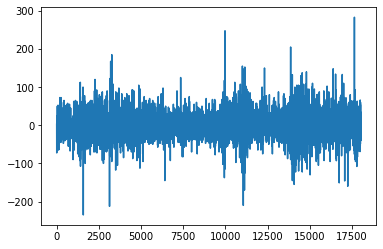

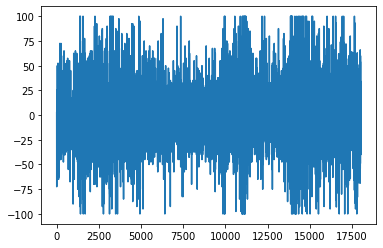

In [ ]:
# Посмотрим на полученный набор, обрежем данные >100 и <-100
xVal1 = np.array(xVal)
xVal1 = np.reshape(xVal1, (-1, 2))
plt.plot(xVal1[:,0])
plt.show()

minmax = 100
for i in range(0, xVal1[:,0].shape[0]):
  if xVal1[i,0] > minmax:
    xVal1[i,0] = minmax
  elif xVal1[i,0] < -minmax:
    xVal1[i,0] = -minmax    

plt.plot(xVal1[:,0])
plt.show()    

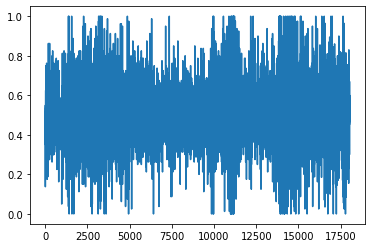

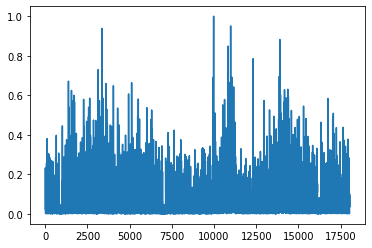

In [ ]:
# Используем MinMaxScaler для нормализации данных на вход модели
ScalerX = MinMaxScaler()
ScalerX.fit(xVal1)
xVal1 = ScalerX.transform(xVal1)
# Посмотрим на данные после нормализации
plt.plot(xVal1[:,0])
plt.show()
plt.plot(xVal1[:,1])
plt.show()

In [ ]:
# Подготавливаем датасет для обучения и для проверки
xVal = np.reshape(xVal1, (np.array(xVal).shape[0],np.array(xVal).shape[1], np.array(xVal).shape[2]))

yVal = np.array(yVal)
yVal = np.reshape(yVal, (yVal.shape[0], 1))

ScalerY = MinMaxScaler()
ScalerY.fit(yVal)
yVal = ScalerY.transform(yVal)

xTrain, xTest, yTrain, yTest = train_test_split(xVal, yVal, test_size=0.1)

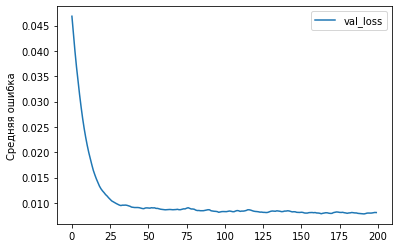

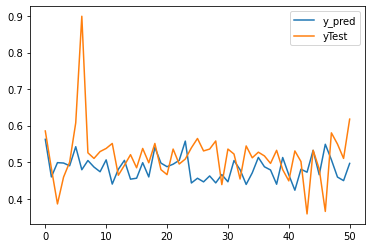

In [ ]:
# Обучаем сеть и смотрим результаты прогноза для данных xTest

model = Sequential()
model.add(Conv1D(8, 6, input_shape = (xTrain.shape[1], xTrain.shape[2]), activation='relu', padding='same'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="relu"))
model.compile(optimizer = Adam(lr=1e-5),
                  loss='mse',
                  metrics=['accuracy'])
checkpoint_callback = ModelCheckpoint('best_model.h5',
                                      monitor='val_loss',
                                      save_best_only=True,
                                      verbose=0)
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

history = model.fit(xTrain, 
                  yTrain,
                  epochs=200,
                  batch_size=40, 
                  verbose=0,
                  callbacks=[checkpoint_callback],
                  validation_data=(xTest, yTest))
model.load_weights('best_model.h5')

# Строим график val_loss
plt.plot(history.history['val_loss'], 
         label='val_loss')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()


# Прогнозируем данные xTest
y_pred = model.predict(xTest)
plt.plot(y_pred, 
         label='y_pred')
plt.plot(yTest, 
         label='yTest')
plt.legend()
plt.show()

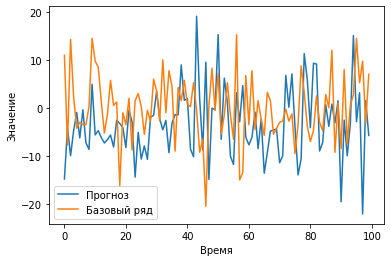

In [ ]:
# Инверсируем предсказанные значения
predVal = ScalerY.inverse_transform(model.predict(xVal))
yValUnscaled = ScalerY.inverse_transform(yVal)

showUnscaled(0, 100, 0, predVal, yValUnscaled)
# Видно что некоторые наборы данных сеть научилась предсказывать